#### Imports

In [2]:
!pip install transforms3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for transforms3d: filename=transforms3d-0.4.1-py3-none-any.whl size=1376772 sha256=50c920379c0ccc3b17284cb337601ad642ea677467c5e219d4bf95f73e8a0c47
  Stored in directory: /root/.cache/pip/wheels/7b/f0/88/0198ac6eca77ffa36e7247595585e9ec34e1dcc327847ebe73
Successfully built transforms3d


In [1]:
!unzip -q '/content/drive/MyDrive/Course Materials/2 Winter 23/ECE 276A Sensing & Estimation in Robotics/Projects/ECE276A_PR2/dataRGBD.zip'

In [3]:
#Imports
import numpy as np
import transforms3d
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import pickle
from IPython.display import clear_output

#### Load data

In [4]:
def load_data(dataset, path):
  '''
  Load data
  '''
  
  with np.load(path+"/data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

  with np.load(path+"/data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamsp = data["time_stamps"]  # acquisition times of the lidar scans
    
  with np.load(path+"/data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # Accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements
  
  with np.load(path+"/data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images
  
  return encoder_counts, encoder_stamps, lidar_angle_min, lidar_angle_max, lidar_angle_increment,\
  lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamsp, imu_angular_velocity, imu_linear_acceleration,\
  imu_stamps, disp_stamps, rgb_stamps

#### Constants

In [5]:
# Constants
path = '/content/drive/MyDrive/Course Materials/2 Winter 23/ECE 276A Sensing & Estimation in Robotics/Projects/ECE276A_PR2/'
datasets = [20, 21]
encoder_counts, encoder_stamps, lidar_angle_min, lidar_angle_max, lidar_angle_increment,\
  lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamsp, imu_angular_velocity, imu_linear_acceleration,\
  imu_stamps, disp_stamps, rgb_stamps = load_data(datasets[0], path)

l = 0.0022
x_offset = 0.29833
y_offset = 0

x_range = np.arange(-0.1,0.1+0.05,0.05)
y_range = np.arange(-0.1,0.1+0.05,0.05)

# Map for details about SLAM plotting and image containing SLAM
MAP = {}
MAP['res']   = 0.05 #meters
MAP['xmin']  = -20  #meters
MAP['ymin']  = -20
MAP['xmax']  =  40
MAP['ymax']  =  40 
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8)

#### Utility function


In [6]:
def save_pickle(var, filename):
  with open(filename, 'wb') as f:
    pickle.dump(var, f, pickle.HIGHEST_PROTOCOL)
  
# Bresenham (as provided)
def bresenham2D(sx, sy, ex, ey):
  '''
  Bresenham's ray tracing algorithm in 2D.
  Inputs:
	  (sx, sy)	start point of ray
	  (ex, ey)	end point of ray
  '''
  sx = int(round(sx))
  sy = int(round(sy))
  ex = int(round(ex))
  ey = int(round(ey))
  dx = abs(ex-sx)
  dy = abs(ey-sy)
  steep = abs(dy)>abs(dx)
  if steep:
    dx,dy = dy,dx # swap 

  if dy == 0:
    q = np.zeros((dx+1,1))
  else:
    q = np.append(0,np.greater_equal(np.diff(np.mod(np.arange( np.floor(dx/2), -dy*dx+np.floor(dx/2)-1,-dy),dx)),0))
  if steep:
    if sy <= ey:
      y = np.arange(sy,ey+1)
    else:
      y = np.arange(sy,ey-1,-1)
    if sx <= ex:
      x = sx + np.cumsum(q)
    else:
      x = sx - np.cumsum(q)
  else:
    if sx <= ex:
      x = np.arange(sx,ex+1)
    else:
      x = np.arange(sx,ex-1,-1)
    if sy <= ey:
      y = sy + np.cumsum(q)
    else:
      y = sy - np.cumsum(q)
  return x,y

def mapCorrelationVectorized(im, x_im, y_im, vp, xs, ys):
  '''
  INPUT 
  im              the map
  [100, 801, 801]
  x_im,y_im       physical x,y positions of the grid map cells
  vp[0:2,:]       occupied x,y positions from range sensor (in physical unit) 
  CHANGING THIS TO [100, 0:2, :] (world frame coordinates)
  xs,ys           physical x,y,positions you want to evaluate "correlation" 

  OUTPUT 
  c               sum of the cell values of all the positions hit by range sensor
  '''
  nx = im.shape[0]
  ny = im.shape[1]
  xmin = x_im[0]
  xmax = x_im[-1]
  xresolution = (xmax-xmin)/(nx-1)
  ymin = y_im[0]
  ymax = y_im[-1]
  yresolution = (ymax-ymin)/(ny-1)
  nxs = xs.size
  nys = ys.size
  cpr = np.zeros((PARTICLES, nxs, nys))

  y1 = np.int16(np.round(((vp[:,1,:,np.newaxis]+ys)-ymin)/yresolution))
  x1 = np.int16(np.round(((vp[:,0,:,np.newaxis]+xs)-ymin)/xresolution))
  y1 = np.transpose(y1, (-1, 0, 1))[:, np.newaxis, :, :]
  x1 = np.transpose(x1, (-1, 0, 1))[np.newaxis, :, :, :]

  cpr = np.transpose(np.sum(im[y1, x1], axis=-1), (-1, 0, 1))
  return cpr

def match_timestamps(ts1, ts2):
  '''
  Map timestamps from ts1 to ts2
  Timestamps in ts1 are used to find nearest timestamps in ts2 and mapped to that index
  Ideally, len(ts1) < len(ts2)
  '''
  if len(ts1) >= len(ts2):
    print('Warning: ts1>=ts2')
  ts_map = {}
  for ts in ts1:
    ts_map[ts] = np.argmin(np.abs(ts-ts2))
  return ts_map

#### Functions

In [7]:
# Dead reckoning trajectory creation
def dead_reckoning_trajectory(trajectory, velocity_robot, imu_angular_velocity, motion_ts_mapped, encoder_time_diff):
  '''
  trajectory            Initialized array to store the trajectory in. It contains the initial pose.
  velocity_robot        Array of velocity of robot calculated from encoder data.
  imu_angular_velocity  Angular velocity along z axis.
  motion_ts_mapped      Timestamp mapping of IMU aangular velocity with encoder wheels
  encoder_time_diff  Time difference at each step. This has been generated from encoder timestamps.

  Append pose values into an array calculating prev_pose + dt*[v_x, v_y, w_z]
  '''
  for i, dt in enumerate(encoder_time_diff[:-1]):
    trajectory.append(trajectory[-1] + (dt * np.array([velocity_robot[i]*np.cos(trajectory[-1][2]),
                                            velocity_robot[i]*np.sin(trajectory[-1][2]), 
                                            imu_angular_velocity[2, motion_ts_mapped[encoder_stamps[i+1]]]])))
  trajectory = np.array(trajectory).T
  return trajectory

# LiDAR to Body Frame
def lidar_to_body_frame(ranges):
  '''
  ranges                Distance readings from the LiDAR. This is 1x1081 for the current project.

  Convert LiDAR ranges to body frame
  '''
  # Generate an array from start to end of angles with provided increments  
  angles = np.arange(lidar_angle_min*180/np.pi,
                     (lidar_angle_max*180/np.pi) + (lidar_angle_increment*180/np.pi),
                     lidar_angle_increment*180/np.pi)*np.pi/180

  # xy position in the sensor frame
  xs0 = ranges*np.cos(angles)
  ys0 = ranges*np.sin(angles)

  # shift from sensor frame to body frame
  xs0 += x_offset
  ys0 += y_offset

  return np.array([xs0, ys0, np.ones(xs0.shape[0])])

# Trajectory to rotation matrix
def trajectory_to_rotation(trajectory):
  '''
  trajectory          Trajectory to be converted into the rotation matrix. .The 1st dimension of this matrix needs to be 3

  Returns 3x3xN matrix for input of 3xN
  Given trajectory = [x, y, theta]
  Return [[cos(theta), -sin(theta), x], [sin(theta), cos(theta), y], [0, 0, 1]]
  
  '''

  assert(trajectory.shape[0] == 3)
  
  # If there are multiple trajectories provided, use this vectorized formulation
  if len(trajectory[0].shape) > 0:
    return np.array([[np.cos(trajectory[2]), -np.sin(trajectory[2]), trajectory[0]],
    [np.sin(trajectory[2]), np.cos(trajectory[2]), trajectory[1]],
    [np.zeros(trajectory.shape[1]), np.zeros(trajectory.shape[1]), np.ones(trajectory.shape[1])]])
  
  else:
    return np.array([[np.cos(trajectory[2]), -np.sin(trajectory[2]), trajectory[0]],
    [np.sin(trajectory[2]), np.cos(trajectory[2]), trajectory[1]], [0, 0, 1]])

# Plotting the LiDAR scan for given index
def lidar_scan(index, trajectory, lidar_ts_mapped, encoder_stamps, map):
  '''
  index               Index for which the trajectory is to be plotted
  lidar_ts_mapped     Mapped values of the LiDAR
  encoder_stamps      Timestamps of encoder reading
  map                 The map in which scan has to be plotted and has all 
  '''

  # Transform LiDAR to world frame
  lidar_to_body = lidar_to_body_frame(lidar_ranges[:, lidar_ts_mapped[encoder_stamps[index]]])
  rotations = trajectory_to_rotation(trajectory[:, index])
  
  Y = np.dot(rotations, lidar_to_body)[:2, :]
  
  # Offset and scale coordinates to plot onto the map
  xis = np.ceil((Y[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
  yis = np.ceil((Y[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
  
  for j in tqdm(range(xis.shape[-1])):
    # Find all coordinates from start to end points and plot into map with log values
    x, y = bresenham2D((trajectory[0, index] - MAP['xmin']) / MAP['res'],
                      (trajectory[1, index] - MAP['ymin']) / MAP['res'], 
                      xis[j], yis[j])
    map[y.astype(np.int16)[:-1], x.astype(np.int16)[:-1]] -= np.log(4)
  map[yis, xis] += np.log(4)
  map[np.where(map<-4*np.log(4))] = -4*np.log(4)
  map[np.where(map>4*np.log(4))] = 4*np.log(4)

  return map

#### SLAM

In [18]:
# Constants for SLAM
PARTICLES = 100
noise_sigma = [0.01, 0.01, 0.001]
x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']  ) #x-positions of each pixel of the map
y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map

In [23]:
# Plotting dead reckoning trajectory
def SLAM(dataset):
  particle_prob = np.ones(PARTICLES)/PARTICLES
  particles = [np.zeros((3, PARTICLES))]
  maximum_correlations = []
  best_particles = []

  encoder_time_diff = encoder_stamps[1:] - encoder_stamps[:-1]
  velocity_left_wheel = (l/2)*np.sum(encoder_counts[[0,2], 1:], axis=0)/encoder_time_diff
  velocity_right_wheel = (l/2)*np.sum(encoder_counts[[1,3], 1:], axis=0)/encoder_time_diff
  velocity_robot = (velocity_left_wheel+velocity_right_wheel)/2
  yaw = imu_angular_velocity[2, 1:] * (imu_stamps[1:] - imu_stamps[:-1])

  motion_ts_mapped = match_timestamps(encoder_stamps[1:], imu_stamps[:-1])
  lidar_ts_mapped = match_timestamps(encoder_stamps, lidar_stamsp)
  
  dead_reckoning = dead_reckoning_trajectory([np.zeros(3)], velocity_robot, imu_angular_velocity, motion_ts_mapped, encoder_time_diff)
  plt.plot(dead_reckoning[0, :], dead_reckoning[1, :])
  plt.xlabel('x coordinate')
  plt.ylabel('y coordinate')
  plt.title('Dead Reckoning Trajectory')
  plt.show()

  plt.plot(dead_reckoning[2])
  plt.xlabel('timestamp')
  plt.ylabel('theta')
  plt.title('Theta')
  plt.show()

  MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']), dtype=np.float16)
  MAP['map'] = lidar_scan(0, dead_reckoning, lidar_ts_mapped, encoder_stamps, MAP['map'])
  plt.figure(figsize = (10, 10))
  plt.title('First LiDAR scan')
  plt.imshow(1/(1+np.exp(-MAP['map'])), cmap='gray')
  plt.show()

  startingMap = lidar_scan(0, dead_reckoning, lidar_ts_mapped, encoder_stamps, MAP['map'])
  logMap = np.zeros((MAP['sizex'],MAP['sizey']), dtype=np.float16)

  log_threshold = 4
  binary_log_threshold = 0
  # Starting prediction
  for t in tqdm(range(1, encoder_stamps.shape[0]-1)):
    # Convert lidar at timestamp t to body frame
    body_frame = lidar_to_body_frame(lidar_ranges[:, lidar_ts_mapped[encoder_stamps[t]]])
  
    # Use the particle poses at previous timestamp to convert from body frame
    # to world frame coordinates
    Y = np.dot(np.transpose(trajectory_to_rotation(particles[-1]), axes=(2, 0, 1)), body_frame)
    xis = np.ceil((Y[:, 0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((Y[:, 1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # xis %= (MAP['sizex'])
    # yis %= (MAP['sizey'])

    correlationValues = mapCorrelationVectorized(startingMap, x_im, y_im, Y, x_range, y_range)
    
    maxCorrelationValues = np.max(correlationValues, axis=(1,2))
    particle_prob *= maxCorrelationValues
    particle_prob = particle_prob/np.sum(particle_prob)

    maxCorr = np.argmax(particle_prob)
    maximum_correlations.append(maxCorr)

    # Changing position of particles based on correlation values
    # for p in range(PARTICLES):
    #   index = np.argmax(correlationValues[p])
    #   a, b = np.unravel_index(index, (y_range.shape[0], x_range.shape[0]))
    #   particles[-1][0, p] += x_range[b]
    #   particles[-1][1, p] += y_range[a]

    start_x = (particles[-1][0, maxCorr] - MAP['xmin']) / MAP['res']
    start_y = (particles[-1][1, maxCorr] - MAP['ymin']) / MAP['res']
    for j in range(xis.shape[1]):
      x, y = bresenham2D(start_x, start_y, xis[maxCorr, j], yis[maxCorr, j])
      logMap[y.astype(np.int16)[:-1], x.astype(np.int16)[:-1]] -= np.log(4)
      # startingMap[y.astype(np.int16)[:-1], x.astype(np.int16)[:-1]] = 1

    # startingMap[yis[maxCorr].astype(np.int16), xis[maxCorr].astype(np.int16)] = 0
    logMap[yis[maxCorr].astype(np.int16), xis[maxCorr].astype(np.int16)] += np.log(4)
    logMap[np.where(logMap<-log_threshold*np.log(4))] = -log_threshold*np.log(4)
    logMap[np.where(logMap>log_threshold*np.log(4))] = log_threshold*np.log(4)
    startingMap[logMap<-binary_log_threshold*np.log(4)] = 1
    startingMap[logMap>binary_log_threshold*np.log(4)] = 0

    best_particles.append(particles[-1][:, maxCorr])
    

    noisy_trajectory = [particles[-1][0] + np.random.normal(0, noise_sigma[0], size=PARTICLES),
                        particles[-1][1] + np.random.normal(0, noise_sigma[1], size=PARTICLES),
                        particles[-1][2] + np.random.normal(0, noise_sigma[2], size=PARTICLES)]
    particles.append(noisy_trajectory +
                    (encoder_time_diff[t] * 
                      np.array([velocity_robot[t]*np.cos(noisy_trajectory[2]),
                                velocity_robot[t]*np.sin(noisy_trajectory[2]),
                                imu_angular_velocity[2, motion_ts_mapped[encoder_stamps[t]]]*np.ones(PARTICLES)])))
    
    # v = velocity_robot[t] + np.random.normal(0, noise_sigma[0], size=PARTICLES)
    # w = yaw_angular_velocity[t] + np.random.normal(0, noise_sigma[2], size=PARTICLES)
    # particles.append(particles[-1] +
    #                  (encoder_time_diff[t] * 
    #                   np.array([v*np.cos(particles[-1][2, :]),
    #                             v*np.sin(particles[-1][2, :]),
    #                             w*np.ones(PARTICLES)]) ))
    
    # Calculate effective number of particles  
    Neff = 1/np.sum(particle_prob**2)
    if Neff<=0.2*PARTICLES:
      print('NEFF', Neff)
      particles[-1] = particles[-1][:, np.random.choice(np.arange(0, PARTICLES), PARTICLES, p=particle_prob)]
      particle_prob = np.ones(PARTICLES)/PARTICLES
    
    if t%500 == 0:
      plt.figure(figsize=(10, 10))
      plt.imshow(1/(1+np.exp(-logMap)), cmap='gray')
      plt.savefig('./plots/log_map_{}_ds_{}.jpg'.format(t, dataset))
      
      plt.figure(figsize=(10, 10))
      plt.imshow(startingMap, cmap='gray')
      plt.savefig('./plots/startingMap_{}_ds_{}.jpg'.format(t, dataset))

      plt.figure(figsize=(10, 10))
      plt.title('SLAM Trajectory')
      plt.plot(best_particles[:, 0], best_particles[:, 1])
      plt.savefig('SLAM_trajectory_{}_{}.jpg'.format(t, dataset))

      plt.figure(figsize=(10, 10))
      plt.title('SLAM Theta')
      plt.plot(best_particles[:, 2])
      plt.savefig('SLAM_theta_{}_{}.jpg'.format(t, dataset))

  best_particles = np.array(best_particles)
  save_pickle(best_particles, 'best_particles_'+str(dataset)+'.pickle')
  save_pickle(logMap, 'logMap'+str(dataset)+'.pickle')
  save_pickle(startingMap, 'startingMap'+str(dataset)+'.pickle')

  plt.figure(figsize=(10, 10))
  plt.title('Particle Filter SLAM Occupancy Map')
  plt.imshow(1/(1+np.exp(-logMap)), cmap = 'gray')
  plt.savefig('Particle Filter SLAM Occupancy Map' + str(dataset)+'.jpg')
  plt.show()

  plt.figure(figsize=(10, 10))
  plt.title('Particle Filter SLAM Binary Map')
  plt.imshow(MAP['map'], cmap = 'gray')
  plt.savefig( 'Particle Filter SLAM Binary Map'+ str(dataset)+'.jpg')
  plt.show()

  plt.figure(figsize=(10, 10))
  plt.title('SLAM Trajectory')
  plt.plot(best_particles[:, 0], best_particles[:, 1])
  plt.savefig('SLAM Trajectory' + str(dataset)+'.jpg')
  plt.show()

  plt.figure(figsize=(10, 10))
  plt.title('SLAM Theta')
  plt.plot(best_particles[:, 2])
  plt.show( 'SLAM Theta'+ str(dataset)+'.jpg')

  return best_particles

#### Texture mapping

In [20]:
texture_dataset_path = '/content/dataRGBD/'

# Constants for texture mapping
roll, pitch, yaw = 0, 0.36, 0.021
kinect_position = np.array([0.18, 0.005, 0.36])
K = np.array([[585.05108211, 0, 242.94140713], [0, 585.05108211, 315.83800193], [0, 0, 1]])
K_inv = np.linalg.inv(K)
R = transforms3d.euler.euler2mat(roll, pitch, yaw)
Ro = np.array([[0, -1, 0], [0, 0, -1], [1, 0, 0]])
Ff = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])
canon_proj = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]])
R_optical_to_reg = np.linalg.inv([[0, -1, 0], [0, 0, -1], [1, 0, 0]])
ROBOT_HEIGHT = 0.254

TEXTURE = {}
TEXTURE['res']   = 0.05 #meters
TEXTURE['xmin']  = -20  #meters
TEXTURE['ymin']  = -20
TEXTURE['xmax']  =  30
TEXTURE['ymax']  =  30 
TEXTURE['sizex']  = int(np.ceil((TEXTURE['xmax'] - TEXTURE['xmin']) / TEXTURE['res'] + 1)) #cells
TEXTURE['sizey']  = int(np.ceil((MAP['ymax'] - TEXTURE['ymin']) / TEXTURE['res'] + 1))
TEXTURE['map'] = np.zeros((TEXTURE['sizex'],TEXTURE['sizey'], 3),dtype=np.int8)
TEXTURE['map'] = np.zeros((2000, 2000, 3),dtype='uint8')

In [21]:
def get_body_frame(dataset_number, image_number, disp_number):
  disp_path = texture_dataset_path+'/Disparity{}/'.format(dataset_number)
  rgb_path = texture_dataset_path+'/RGB{}/'.format(dataset_number)

  imd = cv2.imread(disp_path+'disparity{}_{}.png'.format(dataset_number, image_number),cv2.IMREAD_UNCHANGED) # (480 x 640)
  imc = cv2.imread(rgb_path+'rgb{}_{}.png'.format(dataset_number, image_number))[...,::-1] # (480 x 640 x 3)

  # convert from disparity from uint16 to double
  disparity = imd.astype(np.float32)

  # get depth
  dd = (-0.00304 * disparity + 3.31)
  z = 1.03 / dd

  # calculate u and v coordinates 
  v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
  #u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

  # get 3D coordinates 
  fx = 585.05108211
  fy = 585.05108211
  cx = 315.83800193
  cy = 242.94140713
  x = (u-cx) / fx * z
  y = (v-cy) / fy * z

  # calculate the location of each pixel in the RGB image
  rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
  rgbv = np.round((v * 526.37 + 16662.0)/fy)
  valid = (rgbu>= 0)&(rgbu < disparity.shape[0])&(rgbv>=0)&(rgbv<disparity.shape[1])

  rgbu_flat = rgbu.reshape(-1)
  rgbv_flat = rgbv.reshape(-1)
  
  R_o = K_inv @ (np.array([rgbu_flat, rgbv_flat, np.ones(rgbu_flat.shape[0])]) * z.reshape(-1))

  R_b = (R @ np.dot(R_optical_to_reg, R_o)) + kinect_position[:, np.newaxis]
  return R_b, imc

def trajectory_to_rotation_z(trajectory):
  return np.array([[np.cos(trajectory[2]), -np.sin(trajectory[2]), 0],
    [np.sin(trajectory[2]), np.cos(trajectory[2]), 0], [0, 0, 1]])

def body_to_world(R_b, trajectory):
  return  np.dot(trajectory_to_rotation_z(trajectory), R_b) + \
    np.array([trajectory[0], trajectory[1], ROBOT_HEIGHT])[:, np.newaxis]

def TEXTURE_MAPPING(dataset, best_particles):
  # Timestamp mapping for texture mapping
  disp_ts_mapped = match_timestamps(rgb_stamps, disp_stamps)
  rgb_ts_mapped = match_timestamps(rgb_stamps, encoder_stamps[:best_particles.shape[0]])
  for t in tqdm(range(len(rgb_stamps))):
    R_b, imc = get_body_frame(dataset, t+1, disp_ts_mapped[rgb_stamps[t]])
    traj = best_particles[rgb_ts_mapped[rgb_stamps[t]]-1]
    R_w = body_to_world(R_b, traj)
    
    r,g,b  = cv2.split(imc)
    r=r.reshape(-1, 1)[np.where(R_w[2,:]<=0.5)]
    g=g.reshape(-1, 1)[np.where(R_w[2,:]<=0.5)]
    b=b.reshape(-1, 1)[np.where(R_w[2,:]<=0.5)]

    R_w = R_w[:, np.where(R_w[2]<=0.5)[0]]
    
    xis = np.ceil((R_w[0] - TEXTURE['xmin']) / TEXTURE['res'] ).astype(np.int16)-1
    yis = np.ceil((R_w[1] - TEXTURE['xmin']) / TEXTURE['res'] ).astype(np.int16)-1
    TEXTURE['map'][yis, xis, :] = np.hstack([r, g, b])

  plt.figure(figsize=(10, 10))
  plt.title('Texture Map')
  plt.imshow(TEXTURE['map'], cmap = 'gray')
  plt.savefig( 'Texture Map'+ str(dataset)+'.jpg')
  plt.show()

#### Main

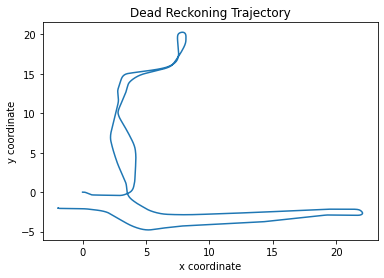

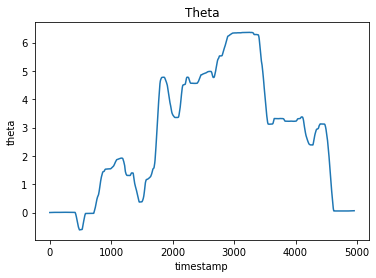

100%|██████████| 1081/1081 [00:00<00:00, 8491.03it/s]


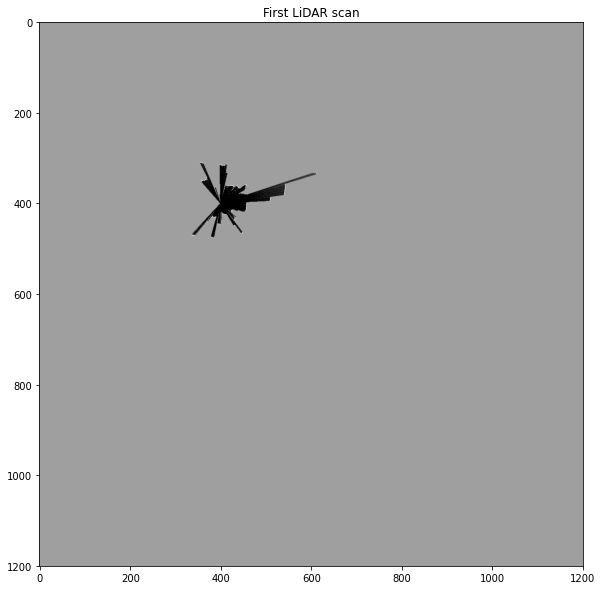

  2%|▏         | 93/4954 [00:22<18:32,  4.37it/s]

NEFF 19.936858373907818


  4%|▎         | 179/4954 [00:50<18:30,  4.30it/s]

NEFF 19.047665303985813


  5%|▍         | 230/4954 [01:03<18:16,  4.31it/s]

NEFF 19.58583985059308


  6%|▌         | 276/4954 [01:15<17:57,  4.34it/s]

NEFF 19.733624145389474


  6%|▋         | 313/4954 [01:24<25:11,  3.07it/s]

NEFF 18.380948308415178


  8%|▊         | 376/4954 [01:41<36:21,  2.10it/s]

NEFF 19.95108459302813


  8%|▊         | 417/4954 [01:51<17:07,  4.42it/s]

NEFF 19.8420857370058


 10%|▉         | 477/4954 [02:06<19:50,  3.76it/s]


KeyboardInterrupt: ignored

In [24]:
def main():
  global encoder_counts, encoder_stamps, lidar_angle_min, lidar_angle_max, lidar_angle_increment,\
  lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamsp, imu_angular_velocity, imu_linear_acceleration,\
  imu_stamps, disp_stamps, rgb_stamps

  for dataset in datasets:
    encoder_counts, encoder_stamps, lidar_angle_min, lidar_angle_max, lidar_angle_increment,\
    lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamsp, imu_angular_velocity, imu_linear_acceleration,\
    imu_stamps, disp_stamps, rgb_stamps = load_data(dataset, path)

    best_particles = SLAM(dataset)
    best_particles = np.array(best_particles)

    TEXTURE['map'] = np.zeros((1500, 1500, 3),dtype='uint8')
    TEXTURE_MAPPING(dataset, best_particles)
main()

In [ ]:
!ls -1 *.pickle | xargs -L1 -I{} cp {} '/content/drive/MyDrive/Course Materials/2 Winter 23/ECE 276A Sensing & Estimation in Robotics/Projects/ECE276A_PR2/'
!ls -1 *.jpg | xargs -L1 -I{} cp {} '/content/drive/MyDrive/Course Materials/2 Winter 23/ECE 276A Sensing & Estimation in Robotics/Projects/ECE276A_PR2/'


97.49641647928895


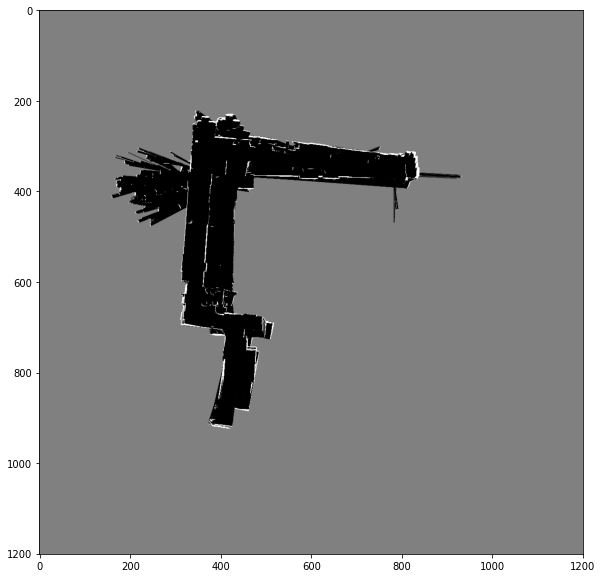

100%|██████████| 2112/2112 [03:40<00:00,  9.57it/s]


In [20]:
#Imports
import numpy as np
import transforms3d
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import pickle
from IPython.display import clear_output

"""#### Load data"""

def load_data(dataset, path):
  '''
  Load data
  '''
  
  with np.load(path+"/data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

  with np.load(path+"/data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamsp = data["time_stamps"]  # acquisition times of the lidar scans
    
  with np.load(path+"/data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # Accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements
  
  with np.load(path+"/data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images
  
  return encoder_counts, encoder_stamps, lidar_angle_min, lidar_angle_max, lidar_angle_increment,\
  lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamsp, imu_angular_velocity, imu_linear_acceleration,\
  imu_stamps, disp_stamps, rgb_stamps

"""#### Constants"""

# Constants
path = '/content/drive/MyDrive/Course Materials/2 Winter 23/ECE 276A Sensing & Estimation in Robotics/Projects/ECE276A_PR2/'
# path = './'
datasets = [20, 21]
encoder_counts, encoder_stamps, lidar_angle_min, lidar_angle_max, lidar_angle_increment,\
  lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamsp, imu_angular_velocity, imu_linear_acceleration,\
  imu_stamps, disp_stamps, rgb_stamps = load_data(datasets[0], path)

l = 0.0022
x_offset = 0.29833
y_offset = 0

x_range = np.arange(-0.2,0.2+0.05,0.05)
y_range = np.arange(-0.2,0.2+0.05,0.05)

# Map for details about SLAM plotting and image containing SLAM
MAP = {}
MAP['res']   = 0.05 #meters
MAP['xmin']  = -20  #meters
MAP['ymin']  = -20
MAP['xmax']  =  40
MAP['ymax']  =  40 
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8)

"""#### Utility function

"""

def save_pickle(var, filename):
  with open(filename, 'wb') as f:
    pickle.dump(var, f, pickle.HIGHEST_PROTOCOL)
  
# Bresenham (as provided)
def bresenham2D(sx, sy, ex, ey):
  '''
  Bresenham's ray tracing algorithm in 2D.
  Inputs:
	  (sx, sy)	start point of ray
	  (ex, ey)	end point of ray
  '''
  sx = int(round(sx))
  sy = int(round(sy))
  ex = int(round(ex))
  ey = int(round(ey))
  dx = abs(ex-sx)
  dy = abs(ey-sy)
  steep = abs(dy)>abs(dx)
  if steep:
    dx,dy = dy,dx # swap 

  if dy == 0:
    q = np.zeros((dx+1,1))
  else:
    q = np.append(0,np.greater_equal(np.diff(np.mod(np.arange( np.floor(dx/2), -dy*dx+np.floor(dx/2)-1,-dy),dx)),0))
  if steep:
    if sy <= ey:
      y = np.arange(sy,ey+1)
    else:
      y = np.arange(sy,ey-1,-1)
    if sx <= ex:
      x = sx + np.cumsum(q)
    else:
      x = sx - np.cumsum(q)
  else:
    if sx <= ex:
      x = np.arange(sx,ex+1)
    else:
      x = np.arange(sx,ex-1,-1)
    if sy <= ey:
      y = sy + np.cumsum(q)
    else:
      y = sy - np.cumsum(q)
  return x,y

def mapCorrelationVectorized(im, x_im, y_im, vp, xs, ys):
  '''
  INPUT 
  im              the map
  [100, 801, 801]
  x_im,y_im       physical x,y positions of the grid map cells
  vp[0:2,:]       occupied x,y positions from range sensor (in physical unit) 
  CHANGING THIS TO [100, 0:2, :] (world frame coordinates)
  xs,ys           physical x,y,positions you want to evaluate "correlation" 

  OUTPUT 
  c               sum of the cell values of all the positions hit by range sensor
  '''
  nx = im.shape[0]
  ny = im.shape[1]
  xmin = x_im[0]
  xmax = x_im[-1]
  xresolution = (xmax-xmin)/(nx-1)
  ymin = y_im[0]
  ymax = y_im[-1]
  yresolution = (ymax-ymin)/(ny-1)
  nxs = xs.size
  nys = ys.size
  cpr = np.zeros((PARTICLES, nxs, nys))

  y1 = np.int16(np.round(((vp[:,1,:,np.newaxis]+ys)-ymin)/yresolution))
  x1 = np.int16(np.round(((vp[:,0,:,np.newaxis]+xs)-ymin)/xresolution))
  y1 = np.transpose(y1, (-1, 0, 1))[:, np.newaxis, :, :]
  x1 = np.transpose(x1, (-1, 0, 1))[np.newaxis, :, :, :]

  cpr = np.transpose(np.sum(im[y1, x1], axis=-1), (-1, 0, 1))
  return cpr

def match_timestamps(ts1, ts2):
  '''
  Map timestamps from ts1 to ts2
  Timestamps in ts1 are used to find nearest timestamps in ts2 and mapped to that index
  Ideally, len(ts1) < len(ts2)
  '''
  if len(ts1) >= len(ts2):
    print('Warning: ts1>=ts2')
  ts_map = {}
  for ts in ts1:
    ts_map[ts] = np.argmin(np.abs(ts-ts2))
  return ts_map

"""#### Functions"""

# Dead reckoning trajectory creation
def dead_reckoning_trajectory(trajectory, velocity_robot, imu_angular_velocity, motion_ts_mapped, encoder_time_diff):
  '''
  trajectory            Initialized array to store the trajectory in. It contains the initial pose.
  velocity_robot        Array of velocity of robot calculated from encoder data.
  imu_angular_velocity  Angular velocity along z axis.
  motion_ts_mapped      Timestamp mapping of IMU aangular velocity with encoder wheels
  encoder_time_diff  Time difference at each step. This has been generated from encoder timestamps.

  Append pose values into an array calculating prev_pose + dt*[v_x, v_y, w_z]
  '''
  for i, dt in enumerate(encoder_time_diff[:-1]):
    trajectory.append(trajectory[-1] + (dt * np.array([velocity_robot[i]*np.cos(trajectory[-1][2]),
                                            velocity_robot[i]*np.sin(trajectory[-1][2]), 
                                            imu_angular_velocity[2, motion_ts_mapped[encoder_stamps[i+1]]]])))
  trajectory = np.array(trajectory).T
  return trajectory

# LiDAR to Body Frame
def lidar_to_body_frame(ranges):
  '''
  ranges                Distance readings from the LiDAR. This is 1x1081 for the current project.

  Convert LiDAR ranges to body frame
  '''
  # Generate an array from start to end of angles with provided increments  
  angles = np.arange(lidar_angle_min*180/np.pi,
                     (lidar_angle_max*180/np.pi) + (lidar_angle_increment*180/np.pi),
                     lidar_angle_increment*180/np.pi)*np.pi/180

  # xy position in the sensor frame
  xs0 = ranges*np.cos(angles)
  ys0 = ranges*np.sin(angles)

  # shift from sensor frame to body frame
  xs0 += x_offset
  ys0 += y_offset

  return np.array([xs0, ys0, np.ones(xs0.shape[0])])

# Trajectory to rotation matrix
def trajectory_to_rotation(trajectory):
  '''
  trajectory          Trajectory to be converted into the rotation matrix. .The 1st dimension of this matrix needs to be 3

  Returns 3x3xN matrix for input of 3xN
  Given trajectory = [x, y, theta]
  Return [[cos(theta), -sin(theta), x], [sin(theta), cos(theta), y], [0, 0, 1]]
  
  '''

  assert(trajectory.shape[0] == 3)
  
  # If there are multiple trajectories provided, use this vectorized formulation
  if len(trajectory[0].shape) > 0:
    return np.array([[np.cos(trajectory[2]), -np.sin(trajectory[2]), trajectory[0]],
    [np.sin(trajectory[2]), np.cos(trajectory[2]), trajectory[1]],
    [np.zeros(trajectory.shape[1]), np.zeros(trajectory.shape[1]), np.ones(trajectory.shape[1])]])
  
  else:
    return np.array([[np.cos(trajectory[2]), -np.sin(trajectory[2]), trajectory[0]],
    [np.sin(trajectory[2]), np.cos(trajectory[2]), trajectory[1]], [0, 0, 1]])

# Plotting the LiDAR scan for given index
def lidar_scan(index, trajectory, lidar_ts_mapped, encoder_stamps, map):
  '''
  index               Index for which the trajectory is to be plotted
  lidar_ts_mapped     Mapped values of the LiDAR
  encoder_stamps      Timestamps of encoder reading
  map                 The map in which scan has to be plotted and has all 
  '''

  # Transform LiDAR to world frame
  lidar_to_body = lidar_to_body_frame(lidar_ranges[:, lidar_ts_mapped[encoder_stamps[index]]])
  rotations = trajectory_to_rotation(trajectory[:, index])
  
  Y = np.dot(rotations, lidar_to_body)[:2, :]
  
  # Offset and scale coordinates to plot onto the map
  xis = np.ceil((Y[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
  yis = np.ceil((Y[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
  
  for j in range(xis.shape[-1]):
    # Find all coordinates from start to end points and plot into map with log values
    x, y = bresenham2D((trajectory[0, index] - MAP['xmin']) / MAP['res'],
                      (trajectory[1, index] - MAP['ymin']) / MAP['res'], 
                      xis[j], yis[j])
    map[y.astype(np.int16)[:-1], x.astype(np.int16)[:-1]] -= np.log(4)
  map[yis, xis] += np.log(4)
  map[np.where(map<-4*np.log(4))] = -4*np.log(4)
  map[np.where(map>4*np.log(4))] = 4*np.log(4)

  return map

"""#### SLAM"""

# Constants for SLAM
PARTICLES = 100
noise_sigma = [0.001, 0.001, 0.0001]
x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']  ) #x-positions of each pixel of the map
y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map

# Plotting dead reckoning trajectory
def SLAM(dataset):
  particle_prob = np.ones(PARTICLES)/PARTICLES
  particles = [np.zeros((3, PARTICLES))]
  maximum_correlations = []
  best_particles = []

  encoder_time_diff = encoder_stamps[1:] - encoder_stamps[:-1]
  velocity_left_wheel = (l/2)*np.sum(encoder_counts[[0,2], 1:], axis=0)/encoder_time_diff
  velocity_right_wheel = (l/2)*np.sum(encoder_counts[[1,3], 1:], axis=0)/encoder_time_diff
  velocity_robot = (velocity_left_wheel+velocity_right_wheel)/2

  motion_ts_mapped = match_timestamps(encoder_stamps[1:], imu_stamps[:-1])
  lidar_ts_mapped = match_timestamps(encoder_stamps, lidar_stamsp)
  
  dead_reckoning = dead_reckoning_trajectory([np.zeros(3)], velocity_robot, imu_angular_velocity, motion_ts_mapped, encoder_time_diff)
  plt.plot(dead_reckoning[0, :], dead_reckoning[1, :])
  plt.xlabel('x coordinate')
  plt.ylabel('y coordinate')
  plt.title('Dead Reckoning Trajectory')
  plt.savefig('./plots/dead_reckoning_trajectory_dt_{}.jpg'.format(dataset))
  plt.close()
  
  plt.plot(dead_reckoning[2])
  plt.xlabel('timestamp')
  plt.ylabel('theta')
  plt.title('Theta')
  plt.savefig('./plots/dead_reckoning_theta_dt_{}.jpg'.format(dataset))
  plt.close()


  MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']), dtype=np.float16)
  MAP['map'] = lidar_scan(0, dead_reckoning, lidar_ts_mapped, encoder_stamps, MAP['map'])
  plt.figure(figsize = (10, 10))
  plt.title('First LiDAR scan')
  plt.imshow(1/(1+np.exp(-MAP['map'])), cmap='gray')
  plt.savefig('./plots/first_LiDAR_scan_dt_{}.jpg'.format(dataset))
  plt.close()

  MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']), dtype=np.float16)
  # for t in tqdm(range(encoder_stamps.shape[0]-1)):
  #   MAP['map'] = lidar_scan(t, dead_reckoning, lidar_ts_mapped, encoder_stamps, MAP['map'])
  plt.figure(figsize = (10, 10))
  plt.title('Dead Reckoning LiDAR scan')
  plt.imshow(1/(1+np.exp(-MAP['map'])), cmap='gray')
  plt.savefig('./plots/dead_reckoning_LiDAR_scan_dt_{}.jpg'.format(dataset))
  plt.close()
  
  startingMap = lidar_scan(0, dead_reckoning, lidar_ts_mapped, encoder_stamps, MAP['map'])
  logMap = np.zeros((MAP['sizex'],MAP['sizey']), dtype=np.float16)

  log_threshold = 4
  binary_log_threshold = 0
  # Starting prediction
  for t in tqdm(range(1, encoder_stamps.shape[0]-1)):
    # Convert lidar at timestamp t to body frame
    body_frame = lidar_to_body_frame(lidar_ranges[:, lidar_ts_mapped[encoder_stamps[t]]])
  
    # Use the particle poses at previous timestamp to convert from body frame
    # to world frame coordinates
    Y = np.dot(np.transpose(trajectory_to_rotation(particles[t-1]),
                            axes=(2, 0, 1)), body_frame)
    xis = np.ceil((Y[:, 0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((Y[:, 1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # xis %= (MAP['sizex'])
    # yis %= (MAP['sizey'])

    correlationValues = mapCorrelationVectorized(startingMap, x_im, y_im, Y, x_range, y_range)
    
    maxCorrelationValues = np.max(correlationValues, axis=(1,2))
    # sigmoidCorrelation = 1/(1+np.exp(-maxCorrelationValues))
    particle_prob *= maxCorrelationValues
    # particle_prob *= np.max(correlationValues, axis=(1,2))
    # particle_prob *= sigmoidCorrelation
    particle_prob = particle_prob/np.sum(particle_prob)
    # particle_prob = np.exp(particle_prob)/np.sum(np.exp(particle_prob))

    maxCorr = np.argmax(particle_prob)
    maximum_correlations.append(maxCorr)

    # Changing position of particles based on correlation values
    # for p in range(PARTICLES):
    #   index = np.argmax(correlationValues[p])
    #   a, b = np.unravel_index(index, (y_range.shape[0], x_range.shape[0]))
    #   particles[-1][0, p] += x_range[b]
    #   particles[-1][1, p] += y_range[a]

    for j in range(xis.shape[1]):
      x, y = bresenham2D((particles[-1][0, maxCorr] - MAP['xmin']) / MAP['res'],
                            (particles[-1][1, maxCorr] - MAP['ymin']) / MAP['res'], 
                            xis[maxCorr, j], yis[maxCorr, j])
      logMap[y.astype(np.int16)[:-1], x.astype(np.int16)[:-1]] -= np.log(4)
    
    logMap[yis[maxCorr].astype(np.int16), xis[maxCorr].astype(np.int16)] += np.log(4)
    logMap[np.where(logMap<-4*np.log(4))] = -4*np.log(4)
    logMap[np.where(logMap>4*np.log(4))] = 4*np.log(4)
    startingMap[logMap<0] = 1
    startingMap[logMap>0] = 0

    best_particles.append(particles[-1][:, maxCorr])
    
    # Calculate effective number of particles  
    Neff = 1/np.sum(particle_prob**2)
    if Neff<=0.2*PARTICLES:
      particles[-1] = particles[-1][:, np.random.choice(np.arange(0, PARTICLES), PARTICLES, p=particle_prob)]
      particle_prob = np.ones(PARTICLES)/PARTICLES

    # noisy_trajectory = [particles[-1][0] + np.random.normal(0, noise_sigma[0], size=PARTICLES),
    #                     particles[-1][1] + np.random.normal(0, noise_sigma[1], size=PARTICLES),
    #                     particles[-1][2] + np.random.normal(0, noise_sigma[2], size=PARTICLES)]
    # particles.append(noisy_trajectory +
    #                  (encoder_time_diff[t] * 
    #                   np.array([velocity_robot[t]*np.cos(noisy_trajectory[2]),
    #                             velocity_robot[t]*np.sin(noisy_trajectory[2]),
    #                             imu_angular_velocity[2, motion_ts_mapped[encoder_stamps[t]]]*np.ones(PARTICLES)]) ))
    
    v = velocity_robot[t] + np.random.normal(0, noise_sigma[0], size=PARTICLES)
    w = imu_angular_velocity[2, motion_ts_mapped[encoder_stamps[t]]]*np.ones(PARTICLES)+ np.random.normal(0, noise_sigma[2], size=PARTICLES)
    particles.append(particles[-1] +
                    (encoder_time_diff[t] * 
                      np.array([v*np.cos(particles[-1][2, :]),
                                v*np.sin(particles[-1][2, :]),
                                w*np.ones(PARTICLES)]) ))
    if t%100==0:
      clear_output()
      print(Neff)
      plt.figure(figsize=(10, 10))
      plt.imshow(1/(1+np.exp(-logMap))  , cmap='gray')
      # plt.imshow(startingMap  , cmap='gray')
      plt.show()
    
    if t%500 == 0:
      plt.figure(figsize=(10, 10))
      plt.imshow(1/(1+np.exp(-logMap)), cmap='gray')
      plt.savefig('./plots/log_map_{}_ds_{}.jpg'.format(t, dataset))
      plt.close()

      plt.figure(figsize=(10, 10))
      plt.imshow(startingMap, cmap='gray')
      plt.savefig('./plots/startingMap_{}_ds_{}.jpg'.format(t, dataset))
      plt.close()

      plt.figure(figsize=(10, 10))
      plt.title('./plots/SLAM Trajectory')
      plt.plot(best_particles[:][0], best_particles[:][1])
      plt.savefig('./plots/SLAM_trajectory_{}_{}.jpg'.format(t, dataset))
      plt.close()

      plt.figure(figsize=(10, 10))
      plt.title('SLAM Theta')
      plt.plot(best_particles[:][2])
      plt.savefig('./plots/SLAM_theta_{}_{}.jpg'.format(t, dataset))
      plt.close('all')
      

  best_particles = np.array(best_particles)
  save_pickle(best_particles, 'best_particles_'+str(dataset)+'.pickle')
  save_pickle(logMap, 'logMap'+str(dataset)+'.pickle')
  save_pickle(startingMap, 'startingMap'+str(dataset)+'.pickle')

  plt.figure(figsize=(10, 10))
  plt.title('Particle Filter SLAM Occupancy Map')
  plt.imshow(1/(1+np.exp(-logMap)), cmap = 'gray')
  plt.savefig('./plots/Particle Filter SLAM Occupancy Map' + str(dataset)+'.jpg')
  plt.close()

  plt.figure(figsize=(10, 10))
  plt.title('Particle Filter SLAM Binary Map')
  plt.imshow(MAP['map'], cmap = 'gray')
  plt.savefig('./plots/Particle Filter SLAM Binary Map'+ str(dataset)+'.jpg')
  plt.close()

  plt.figure(figsize=(10, 10))
  plt.title('SLAM Trajectory')
  plt.plot(best_particles[:, 0], best_particles[:, 1])
  plt.savefig('./plots/SLAM Trajectory' + str(dataset)+'.jpg')
  plt.close()

  plt.figure(figsize=(10, 10))
  plt.title('SLAM Theta')
  plt.plot(best_particles[:, 2])
  plt.savefig('./plots/SLAM Theta'+ str(dataset)+'.jpg')
  plt.close()

  return best_particles

"""#### Texture mapping"""

texture_dataset_path = './dataRGBD/'

# Constants for texture mapping
roll, pitch, yaw = 0, 0.36, 0.021
kinect_position = np.array([0.18, 0.005, 0.36])
K = np.array([[585.05108211, 0, 242.94140713], [0, 585.05108211, 315.83800193], [0, 0, 1]])
K_inv = np.linalg.inv(K)
R = transforms3d.euler.euler2mat(roll, pitch, yaw)
Ro = np.array([[0, -1, 0], [0, 0, -1], [1, 0, 0]])
Ff = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])
canon_proj = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]])
R_optical_to_reg = np.linalg.inv([[0, -1, 0], [0, 0, -1], [1, 0, 0]])
ROBOT_HEIGHT = 0.254

TEXTURE = {}
TEXTURE['res']   = 0.05 #meters
TEXTURE['xmin']  = -20  #meters
TEXTURE['ymin']  = -20
TEXTURE['xmax']  =  30
TEXTURE['ymax']  =  30 
TEXTURE['sizex']  = int(np.ceil((TEXTURE['xmax'] - TEXTURE['xmin']) / TEXTURE['res'] + 1)) #cells
TEXTURE['sizey']  = int(np.ceil((MAP['ymax'] - TEXTURE['ymin']) / TEXTURE['res'] + 1))
TEXTURE['map'] = np.zeros((TEXTURE['sizex'],TEXTURE['sizey'], 3),dtype=np.int8)
TEXTURE['map'] = np.zeros((1500, 1500, 3),dtype='uint8')

def get_body_frame(dataset_number, image_number, disp_number):
  disp_path = texture_dataset_path+'/Disparity{}/'.format(dataset_number)
  rgb_path = texture_dataset_path+'/RGB{}/'.format(dataset_number)

  imd = cv2.imread(disp_path+'disparity{}_{}.png'.format(dataset_number, image_number),cv2.IMREAD_UNCHANGED) # (480 x 640)
  imc = cv2.imread(rgb_path+'rgb{}_{}.png'.format(dataset_number, image_number))[...,::-1] # (480 x 640 x 3)

  # convert from disparity from uint16 to double
  disparity = imd.astype(np.float32)

  # get depth
  dd = (-0.00304 * disparity + 3.31)
  z = 1.03 / dd

  # calculate u and v coordinates 
  v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
  #u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

  # get 3D coordinates 
  fx = 585.05108211
  fy = 585.05108211
  cx = 315.83800193
  cy = 242.94140713
  x = (u-cx) / fx * z
  y = (v-cy) / fy * z

  # calculate the location of each pixel in the RGB image
  rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
  rgbv = np.round((v * 526.37 + 16662.0)/fy)
  valid = (rgbu>= 0)&(rgbu < disparity.shape[0])&(rgbv>=0)&(rgbv<disparity.shape[1])

  rgbu_flat = rgbu.reshape(-1)
  rgbv_flat = rgbv.reshape(-1)
  
  R_o = K_inv @ (np.array([rgbu_flat, rgbv_flat, np.ones(rgbu_flat.shape[0])]) * z.reshape(-1))

  R_b = (R @ np.dot(R_optical_to_reg, R_o)) + kinect_position[:, np.newaxis]
  return R_b, imc

def trajectory_to_rotation_z(trajectory):
  return np.array([[np.cos(trajectory[2]), -np.sin(trajectory[2]), 0],
    [np.sin(trajectory[2]), np.cos(trajectory[2]), 0], [0, 0, 1]])

def body_to_world(R_b, trajectory):
  return  np.dot(trajectory_to_rotation_z(trajectory), R_b) + \
    np.array([trajectory[0], trajectory[1], ROBOT_HEIGHT])[:, np.newaxis]

def TEXTURE_MAPPING(dataset, best_particles):
  # Timestamp mapping for texture mapping
  disp_ts_mapped = match_timestamps(rgb_stamps, disp_stamps)
  rgb_ts_mapped = match_timestamps(rgb_stamps, encoder_stamps[:best_particles.shape[0]])
  for t in tqdm(range(len(rgb_stamps))):
    R_b, imc = get_body_frame(dataset, t+1, disp_ts_mapped[rgb_stamps[t]])
    traj = best_particles[rgb_ts_mapped[rgb_stamps[t]]-1]
    R_w = body_to_world(R_b, traj)
    
    r,g,b  = cv2.split(imc)
    r=r.reshape(-1, 1)[np.where(R_w[2,:]<=0.5)]
    g=g.reshape(-1, 1)[np.where(R_w[2,:]<=0.5)]
    b=b.reshape(-1, 1)[np.where(R_w[2,:]<=0.5)]

    R_w = R_w[:, np.where(R_w[2]<=0.5)[0]]
    
    xis = np.ceil((R_w[0] - TEXTURE['xmin']) / TEXTURE['res'] ).astype(np.int16)-1
    yis = np.ceil((R_w[1] - TEXTURE['xmin']) / TEXTURE['res'] ).astype(np.int16)-1
    TEXTURE['map'][yis, xis, :] = np.hstack([r, g, b])
  
    if t%500 == 0 and t!=0:
      plt.figure(figsize=(10, 10))
      plt.imshow(TEXTURE['map'])
      plt.savefig('./plots/texture_map_{}_ds_{}.jpg'.format(t, dataset))
      plt.close()

  save_pickle(TEXTURE['map'], 'texture_map_'+str(dataset)+'.pickle')
  plt.figure(figsize=(10, 10))
  plt.title('Texture Map')
  plt.imshow(TEXTURE['map'], cmap = 'gray')
  plt.savefig('./plots/Texture Map'+ str(dataset)+'.jpg')
  plt.close()


"""#### Main"""
if __name__ == '__main__':
  for dataset in datasets:
    encoder_counts, encoder_stamps, lidar_angle_min, lidar_angle_max, lidar_angle_increment,\
    lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamsp, imu_angular_velocity, imu_linear_acceleration,\
    imu_stamps, disp_stamps, rgb_stamps = load_data(dataset, path)

    best_particles = SLAM(dataset)
    best_particles = np.array(best_particles)
    
    TEXTURE['map'] = np.zeros((3000, 3000, 3),dtype='uint8')
    TEXTURE_MAPPING(dataset, best_particles)